# setup

In [19]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [20]:
import pathlib
import matplotlib.pyplot as plt
import lasio
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from scipy import signal
from segysak.segy import get_segy_texthead, segy_header_scan, segy_header_scrape, segy_loader
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.linalg import toeplitz
from numpy.linalg import lstsq

In [21]:
#Ordem de inputs da funcao: 1 - profundidade, 2- curva de poco que deseja filtrar parta a escala sismica, 3 -dado sismico 3D
#4- ponto mais raso em profundidade (equivalente ao corte inicial do dado sismico),
#5- ponto mais profundo(equivalente ao corte final do dado sismico)
def escala_sismica(depth,curva_poco,dado_sismico,depth_point1,depth_point2): 
    wells=[]
    
    wells.append(np.array([depth,curva_poco]).T)
    #print(wells)
    npocos = 1
    avgParam = 1 #parameter used for
    upperLimit = depth_point2#intersection of points
    lowerLimit = depth_point1
    columns = [] 
    jumpvec =[]
    inivec = np.zeros(npocos)
    endvec = np.zeros(npocos)
    dzi = np.zeros(npocos)
    indw = 0
    
    for well in wells:
        depthX = 0
        dzi[indw] = well[3,0] -well[2,0]
        ini, end = -1, -1
        for i in range(well.shape[0]):
            if well[i, 0] >= lowerLimit and well[i, 0] <= upperLimit:
                depthX += 1
                if ini == -1:
                    ini = i
            elif ini != -1:
                end = i-1
                break
        if end == -1:# in case is the whole well
            end = well.shape[0]-1
        jump = (depthX-1)/(dado_sismico.shape[2])
        
        inivec[indw] = ini
        endvec[indw] = end
        indw +=1
    
        jumpvec.append([math.floor(jump)])
        columns.append([math.floor(ini + j*jump) for j in range(dado_sismico.shape[2]+1)])
    
    jumpvec =np.array(jumpvec)

    wellsF =[]
    for i in range(len(wells)):
        auxWell = []
        #print(np.shape(inivec))
    
        # cria dados de poco com filtro
        auxWellF = []
    
        a = math.floor(inivec[i])

        #vetores com dados originais do poco selecionados na faixa de 200m
        auxcurva = wells[i][math.floor(inivec[i]):math.floor(endvec[i]),1]
        
        # escala dos dados sismicos em metros
        lb = 5
        #escala do poco i e'  dada por   (200/(endvec[i] - inivec[i]))
        ep =(200/(endvec[i] - inivec[i]))

        Timepoco  = np.arange(np.shape(auxcurva)[0])

        vpmedio = 4.865042027693202 #km/s
        dti = 2 * dzi[i]  / (1000 * vpmedio)   # dzi[i]  passo de profundidade poco poco i em metros
        Timepoco = Timepoco * dti
        nfiltp  = 3
        #60 na linha abaixo  corresponde 60 Hertz que define o corte no filtro (frequencias acima de 60 são cortadas)
        cutofffrp =  2 * 60 * dti
        #print(dti,cutofffrp)
        bp, ap = signal.butter(nfiltp, cutofffrp)
        curvafilt = signal.filtfilt(bp, ap, np.squeeze(auxcurva))
        
        for j in range((dado_sismico.shape[2])):

            curvaiF = curvafilt[j*jumpvec[i]]

            auxWellF.append([curvaiF])
        
        j = (dado_sismico.shape[2]) 
        curvaiF = curvafilt[j*jumpvec[i]-1]
        auxWellF.append([curvaiF])
    
        wellsF.append(auxWellF)

        wellsF[i] = np.array(auxWellF)

    wells = np.array(wellsF)
    return wells[0,:,0,0]

In [119]:
def wavl(ref, seis, proj = False):
    # proj = False
    # ref é a refletividade da wavelet
    R = toeplitz(ref)

    clf = linear_model.Ridge(alpha=0.005, fit_intercept=False)
    clf.fit(R, seis) # seis é o array de traço sísmico

    if proj: # se você quiser projetar a wavelet para que ela tenha uma amplitude não-zero numa area reduzida proj = True
        wavelet_size = 20 # samples
        opProj = np.zeros((seis.size, seis.size))

        opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)

        op  = np.dot(R, opProj)
        wav = lstsq(op, seis, rcond = None)[0]
    else:
        wav = clf.coef_
    synth = R.dot(wav) # traço sintético gerado pela wavelet
    cur_cor = np.corrcoef(seis, synth)[0][1] # correlação do traço sintético com o traço sísmico real
    print(cur_cor)
    return wav, synth

In [122]:
def cross(Rpp, wvlt):
    R = toeplitz(Rpp)
    synth = R.dot(wvlt)
    return synth

In [23]:
def RC_fwd_model_ia(ia1, ia2):
    Rpp = (ia2 - ia1) / (ia2 + ia1)
    return Rpp

# sismica

In [24]:
V3D_path = pathlib.Path("data/dados/buzios_corte_tempo.sgy")
print("3D", V3D_path, V3D_path.exists())

3D data/dados/buzios_corte_tempo.sgy True


In [25]:
scan = segy_header_scan(V3D_path)
scan

100%|██████████| 1.00k/1.00k [00:00<00:00, 22.6k traces/s]


,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
TRACE_SEQUENCE_FILE,5,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,4004.713,0.699371,4004.0,4004.00,4005.0,4005.00,4006.0
TraceNumber,13,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...
SourceEnergyDirectionMantissa,219,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceEnergyDirectionExponent,223,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementMantissa,225,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0


In [26]:
scrape = segy_header_scrape(V3D_path, partial_scan=1000)
scrape

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

100%|██████████| 1.00k/1.00k [00:00<00:00, 22.9k traces/s]


,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,1,1,4004,0,0,2150,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,4004,0,0,2151,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3,4004,0,0,2152,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,4,4004,0,0,2153,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,5,4004,0,0,2154,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,996,4006,0,0,2287,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
996,997,997,4006,0,0,2288,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
997,998,998,4006,0,0,2289,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
998,999,999,4006,0,0,2290,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
V3D = segy_loader(V3D_path, iline=189, xline=193, cdpx=73, cdpy=77, vert_domain="TWT")
V3D

100%|██████████| 73.3k/73.3k [00:03<00:00, 22.2k traces/s]


Loading as 3D
Fast direction is INLINE_3D


Converting SEGY: 100%|██████████| 73.3k/73.3k [00:11<00:00, 6.29k traces/s]


<xarray.Dataset>
Dimensions:  (iline: 172, xline: 429, twt: 24)
Coordinates:
  * iline    (iline) uint16 4004 4005 4006 4007 4008 ... 4172 4173 4174 4175
  * xline    (xline) uint16 2150 2151 2152 2153 2154 ... 2577 2578 2579 2580
  * twt      (twt) float64 4.948e+03 4.952e+03 4.956e+03 ... 5.036e+03 5.04e+03
    cdp_x    (iline, xline) float32 7.542e+05 7.542e+05 ... 7.562e+05 7.562e+05
    cdp_y    (iline, xline) float32 7.251e+06 7.251e+06 ... 7.258e+06 7.258e+06
Data variables:
    data     (iline, xline, twt) float32 0.1019 0.2756 ... -0.01059 0.5266
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 3D VOLUME\nC 2 HEADER BYTE LOCATIONS AND TYPES:\...
    measurement_system:  0
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         buzios_corte_tempo.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-0.7709436503262265, -0.7692768242923893, -0.647411...
    coord_scalar:        -10.0

Text(0.5, 0, 'XLINE')

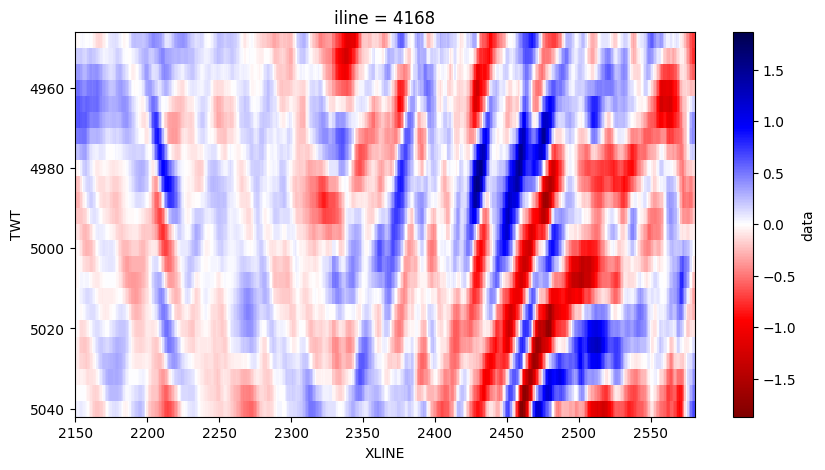

In [28]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
iline_sel = 4168
V3D.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
# plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")
# plt.savefig('seismic_depth_4480.png')

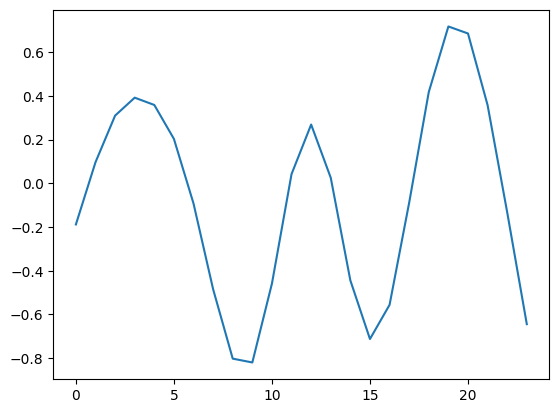

In [29]:
plt.plot(V3D.data.sel(iline=iline_sel,xline=2525).data);

In [109]:
coord3 = [4131, 2572]
coord5 = [4075, 2472]
coord8 = [4102, 2360]
coord9 = [4070, 2155]
coord12 = [4168, 2525]
coord14 = [4065, 2492]
coord18 = [4114, 2500]

In [30]:
sismica3 = V3D.data.sel(iline = 4131, xline = 2572).data
sismica5 = V3D.data.sel(iline = 4075, xline = 2472).data
sismica8 = V3D.data.sel(iline = 4102, xline = 2360).data
sismica9 = V3D.data.sel(iline = 4070, xline = 2155).data
sismica12 = V3D.data.sel(iline = 4168, xline = 2525).data
sismica14 = V3D.data.sel(iline = 4065, xline = 2492).data
sismica18 = V3D.data.sel(iline = 4114, xline = 2500).data

# poço

In [31]:
def porosity_calc(rho_b, rho_ma, rho_f):
    rho_n = np.array(rho_b)
    phi_calc = np.zeros(rho_n.size)
    for i in range(rho_n.size):
        phi_calc[i] = ((rho_n[i] - rho_ma) / (rho_f-rho_ma))*100

    return phi_calc

In [32]:
# well1 = lasio.read('7buz12rjs_editadas.las')
# well2 = lasio.read('7-buz-14da-rjs_curvas_basicas.las')
well3 = lasio.read('data/dados/7buz23rjs.las')
# well4 = lasio.read('7-buz-25-rjs_curvas_basicas.las')
well5 = lasio.read('data/dados/7-buz-29-rjs.las')
# well6 = lasio.read('7-buz-31d-rjs_curvas_basicas.las')
# well7 = lasio.read('8-BUZ-21D-RJS_editadas.las')
well8 = lasio.read('data/dados/8-buz-26-rjs.las')
well9 = lasio.read('data/dados/8buz28da.las')
# well10 = lasio.read('8-buz-32da-rjs_curvas_basicas.las')
# well11 = lasio.read('8buz15rjs_edit.las')
well12 = lasio.read('data/dados/8buz20rjs.las')
# well13 = lasio.read('3-BRSA-1184-RJS-las.las')
well14 = lasio.read('data/dados/7-buz-10-rjs.las')
# well15 = lasio.read('7-BUZ-30-RJS-las.las')
# well16 = lasio.read('8-BUZ-9-RJS-las.las')
# well20 = lasio.read('9-BRSA-1191-RJS-las.las') #converter nphi para porcentagem
# well18 = lasio.read('9-BUZ-4-RJS-las.las')
# well19 = lasio.read('9-BUZ-8-RJS-las.las')

##
# well17 = lasio.read('9-BRSA-1197-RJS-las.las') #Utilizar para gerar figura, converter nphi para porcentagem
well18 = lasio.read('data/dados/3-brsa-1053-rjs.las')

In [33]:
well3_df = well3.df().dropna(how = 'any', axis=0)
well5_df = well5.df().dropna(how = 'any', axis=0)
well8_df = well8.df().dropna(how = 'any', axis=0)
well9_df = well9.df().dropna(how = 'any', axis=0)
well12_df = well12.df().dropna(how = 'any', axis=0)
well14_df = well14.df().dropna(how = 'any', axis=0)
well18_df = well18.df().dropna(how = 'any', axis=0)

In [59]:
data3 = well3_df
res3 = np.array(data3['BRRESP'])[+150:]
rho3 = np.array(data3['BRDENS'])[+150:]
dtp3 = np.array(data3['BRDTP'])[+150:]
dts3 = np.array(data3['BRDTS'])[+150:]
phi3 = np.array(data3['BRNEUT'])[+150:]
gr3 = np.array(data3['BRGR'])[+150:]
z3 = data3.index[+150:]

vp3 = (10**3/dtp3)*0.3048 #km/s
vs3 = (10**3/dts3)*0.3048 #km/s

phi_den3 = porosity_calc(rho3,2.8,1.05)

twt3 = np.array(data3['TWT'])[+150:]

In [60]:
data5 = well5_df
res5 = np.array(data5['BRRESP'])[+150:]
rho5 = np.array(data5['BRDENS'])[+150:]
dtp5 = np.array(data5['BRDTP'])[+150:]
phi5 = np.array(data5['BRNEUT'])[+150:]
gr5 = np.array(data5['BRGR'])[+150:]
z5 = data5.index[+150:]

vp5 = (10**3/dtp5)*0.3048 #km/s

phi_den5 = porosity_calc(rho5,2.8,1.05)

twt5 = np.array(data5['TWT'])[+150:]

In [61]:
data8 = well8_df
res8 = np.array(data8['BRRESP'])[+14200:]
rho8 = np.array(data8['BRDENS'])[+14200:]
dtp8 = np.array(data8['BRDTP'])[+14200:]
phi8 = np.array(data8['BRNEUT'])[+14200:]
gr8 = np.array(data8['BRGR'])[+14200:]
z8 = data8.index[+14200:]

vp8 = (10**3/dtp8)*0.3048 #km/s

phi_den8 = porosity_calc(rho8,2.8,1.05)

twt8 = np.array(data8['TWT'])[+14200:]

In [62]:
data9 = well9_df
res9 = np.array(data9['BRRESP'])
rho9 = np.array(data9['BRDENS'])
dtp9 = np.array(data9['BRDTP'])
phi9 = np.array(data9['BRNEUT'])
gr9 = np.array(data9['BRGR'])
z9 = data9.index

vp9 = (10**3/dtp9)*0.3048 #km/s

phi_den9 = porosity_calc(rho9,2.8,1.05)

twt9 = np.array(data9['TWT'])

In [63]:
data12 = well12_df
res12 = np.array(data12['BRRESP'])
rho12 = np.array(data12['BRDENS'])
dtp12 = np.array(data12['BRDTP'])
phi12 = np.array(data12['BRNEUT'])
gr12 = np.array(data12['BRGR'])
z12 = data12.index

vp12 = (10**3/dtp12)*0.3048 #km/s

phi_den12 = porosity_calc(rho12,2.8,1.05)

twt12 = np.array(data12['TWT'])

In [64]:
data14 = well14_df
# res14 = np.array(data14['RT90'])[+500:-500]
# rho14 = np.array(data14['RHOB'])[+500:-500]
# dtp14 = np.array(data14['DT'])[+500:-500]
# phi14 = np.array(data14['NPHI'])[+500:-500]
# gr14 = np.array(data14['GR'])[+500:-500]
# z14 = data14.index[+500:-500]
res14 = np.array(data14['RT90'])
rho14 = np.array(data14['RHOB'])
dtp14 = np.array(data14['DT'])
phi14 = np.array(data14['NPHI'])
gr14 = np.array(data14['GR'])
z14 = data14.index

vp14 = (10**3/dtp14)*0.3048 #km/s

phi_den14 = porosity_calc(rho14,2.8,1.05)

twt14 = np.array(data14['TWT'])

In [65]:
data18 = well18_df
res18 = np.array(data18['BRRESP'])
rho18 = np.array(data18['BRDENS'])
dtp18 = np.array(data18['BRDTP'])
phi18 = np.array(data18['BRNEUT'])*1e2
gr18 = np.array(data18['BRGR'])
z18 = data18.index

vp18 = (10**3/dtp18)*0.3048 #km/s

phi_den18 = porosity_calc(rho18,2.8,1.05)

twt18 = np.array(data18['TWT'])

# inversao

In [ ]:
depth_point1 = 4948
depth_point2 = 5040

## well 3

In [66]:
idx3 = (twt3 > depth_point1) * (twt3 < depth_point2)
imp3 = vp3 * rho3

philow3 = escala_sismica(twt3[idx3], phi3[idx3], np.array(V3D.data), depth_point1, depth_point2)
implow3 = escala_sismica(twt3[idx3], imp3[idx3], np.array(V3D.data), depth_point1, depth_point2)

Rpp3 = RC_fwd_model_ia(implow3[:-1], implow3[1:])
Rpplast3 = 0.0 / implow3[0]
Rpp3 = np.concatenate([Rpp3, np.expand_dims(Rpplast3, axis = 0)], axis = 0)

0.43016392241608603


(24,)

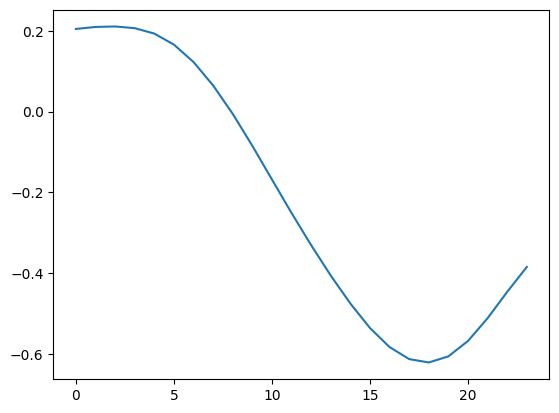

In [121]:
wvlt3, synth3 = wavl(Rpp3[:-1], sismica3)
plt.plot(wvlt3);
wvlt3.shape

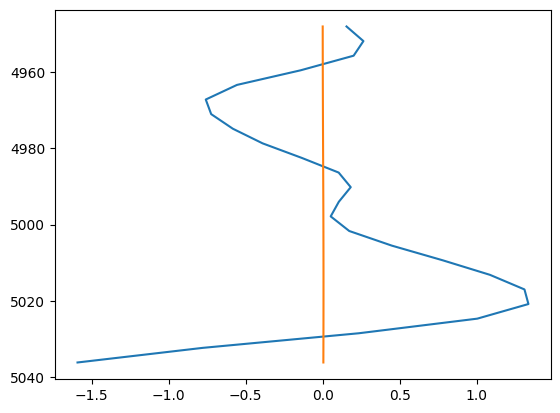

In [72]:
zz = np.linspace(depth_point1, depth_point2, synth3.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth3, zz[:-1]);
plt.gca().invert_yaxis();

0.7580056704918894


(24,)

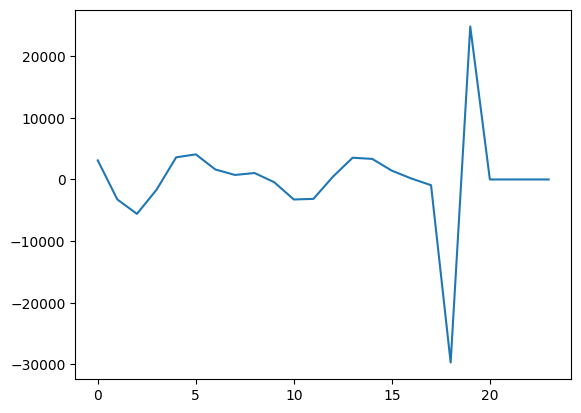

In [120]:
wvlt3proj, synth3proj = wavl(Rpp3[:-1], sismica3, proj = True)
plt.plot(wvlt3proj);
wvlt3proj.shape

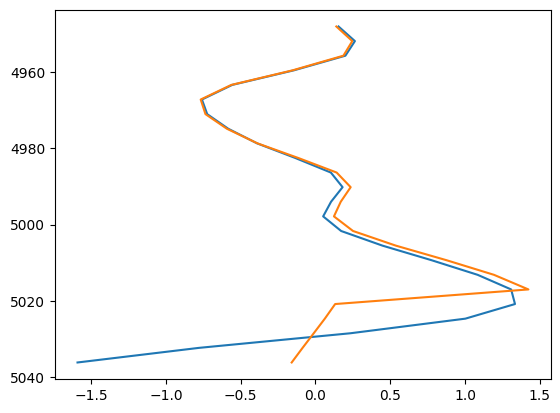

In [96]:
zz = np.linspace(depth_point1, depth_point2, synth3proj.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth3proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 5

In [73]:
idx5 = (twt5 > depth_point1) * (twt5 < depth_point2)
imp5 = vp5 * rho5

philow5 = escala_sismica(twt5[idx5], phi5[idx5], np.array(V3D.data), depth_point1, depth_point2)
implow5 = escala_sismica(twt5[idx5], imp5[idx5], np.array(V3D.data), depth_point1, depth_point2)

Rpp5 = RC_fwd_model_ia(implow5[:-1], implow5[1:])
Rpplast5 = 0.0 / implow5[0]
Rpp5 = np.concatenate([Rpp5, np.expand_dims(Rpplast5, axis = 0)], axis = 0)

0.3980494335842201


(24,)

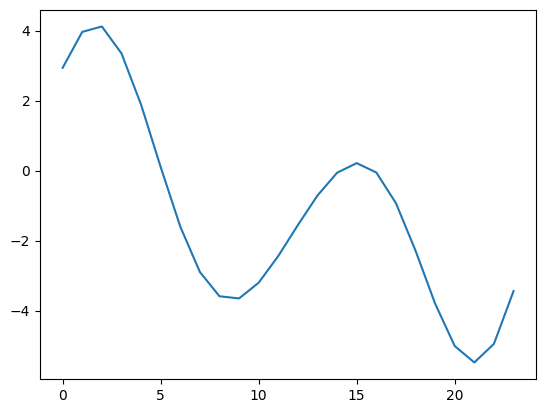

In [78]:
wvlt5, synth5 = wavl(Rpp5[:-1], sismica5)
plt.plot(wvlt5);
wvlt5.shape

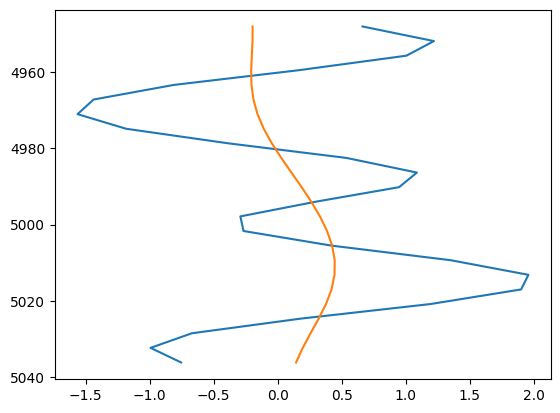

In [79]:
zz = np.linspace(depth_point1, depth_point2, synth5.shape[0] + 1)
plt.plot(sismica5, zz[:-1]);
plt.plot(synth5, zz[:-1]);
plt.gca().invert_yaxis();

0.880253462442855


(24,)

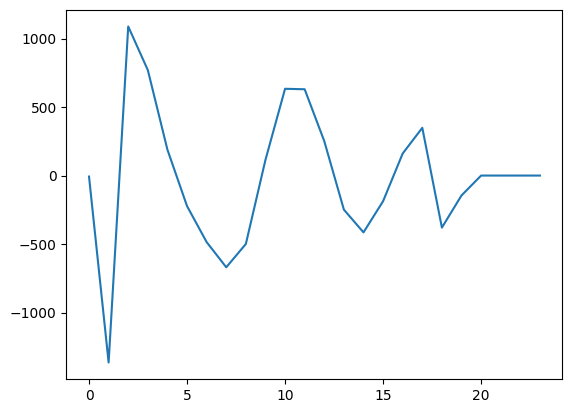

In [97]:
wvlt5proj, synth5proj = wavl(Rpp5[:-1], sismica5, proj = True)
plt.plot(wvlt5proj);
wvlt5proj.shape

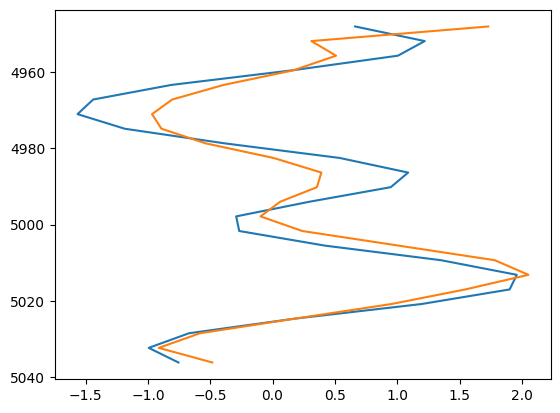

In [98]:
zz = np.linspace(depth_point1, depth_point2, synth5proj.shape[0] + 1)
plt.plot(sismica5, zz[:-1]);
plt.plot(synth5proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 8

In [80]:
idx8 = (twt8 > depth_point1) * (twt8 < depth_point2)
imp8 = vp8 * rho8

philow8 = escala_sismica(twt8[idx8], phi8[idx8], np.array(V3D.data), depth_point1, depth_point2)
implow8 = escala_sismica(twt8[idx8], imp8[idx8], np.array(V3D.data), depth_point1, depth_point2)

Rpp8 = RC_fwd_model_ia(implow8[:-1], implow8[1:])
Rpplast8 = 0.0 / implow8[0]
Rpp8 = np.concatenate([Rpp8, np.expand_dims(Rpplast8, axis = 0)], axis = 0)

0.8716643342192458


(24,)

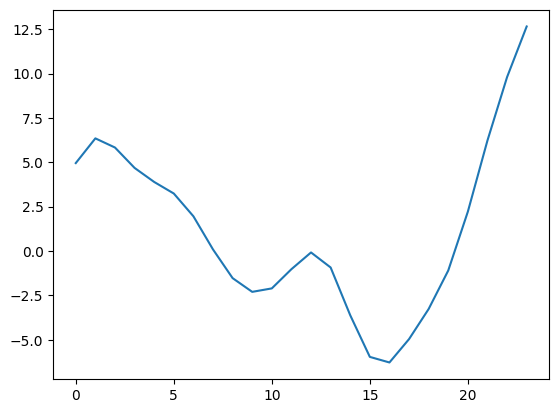

In [81]:
wvlt8, synth8 = wavl(Rpp8[:-1], sismica8)
plt.plot(wvlt8);
wvlt8.shape

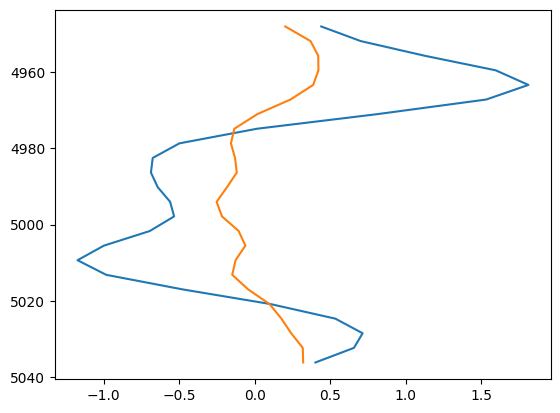

In [82]:
zz = np.linspace(depth_point1, depth_point2, synth8.shape[0] + 1)
plt.plot(sismica8, zz[:-1]);
plt.plot(synth8, zz[:-1]);
plt.gca().invert_yaxis();

0.9684485507072633


(24,)

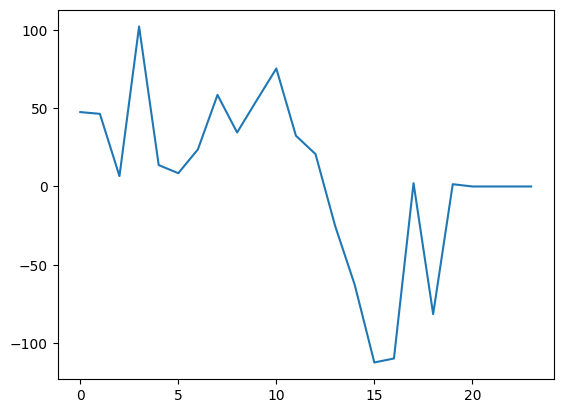

In [99]:
wvlt8proj, synth8proj = wavl(Rpp8[:-1], sismica8, proj = True)
plt.plot(wvlt8proj);
wvlt8proj.shape

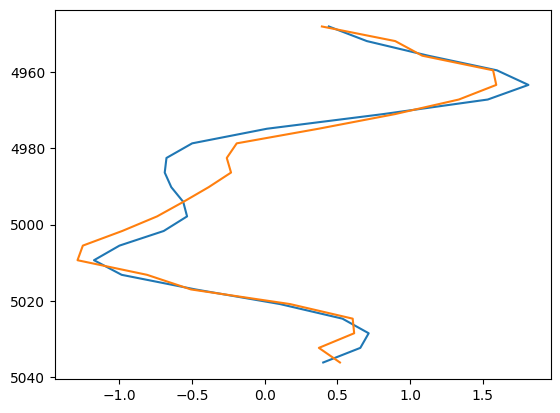

In [100]:
zz = np.linspace(depth_point1, depth_point2, synth8proj.shape[0] + 1)
plt.plot(sismica8, zz[:-1]);
plt.plot(synth8proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 9

In [83]:
idx9 = (twt9 > depth_point1) * (twt9 < depth_point2)
imp9 = vp9 * rho9

philow9 = escala_sismica(twt9[idx9], phi9[idx9], np.array(V3D.data), depth_point1, depth_point2)
implow9 = escala_sismica(twt9[idx9], imp9[idx9], np.array(V3D.data), depth_point1, depth_point2)

Rpp9 = RC_fwd_model_ia(implow9[:-1], implow9[1:])
Rpplast9 = 0.0 / implow9[0]
Rpp9 = np.concatenate([Rpp9, np.expand_dims(Rpplast9, axis = 0)], axis = 0)

0.709822782960714


(24,)

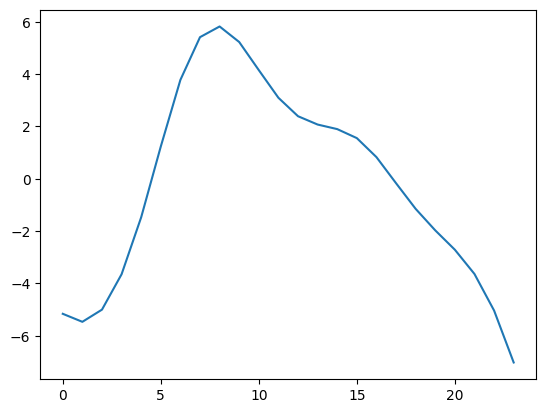

In [84]:
wvlt9, synth9 = wavl(Rpp9[:-1], sismica9)
plt.plot(wvlt9);
wvlt9.shape

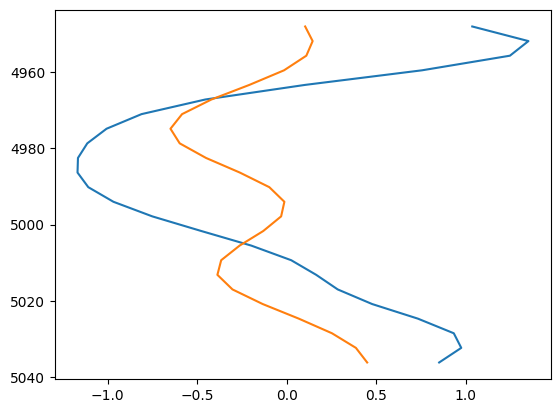

In [85]:
zz = np.linspace(depth_point1, depth_point2, synth9.shape[0] + 1)
plt.plot(sismica9, zz[:-1]);
plt.plot(synth9, zz[:-1]);
plt.gca().invert_yaxis();

0.9998889713251469


(24,)

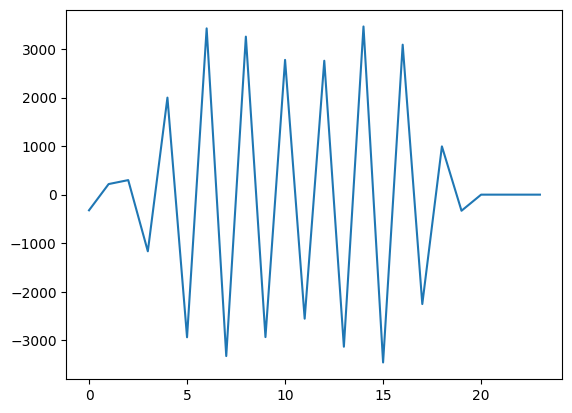

In [101]:
wvlt9proj, synth9proj = wavl(Rpp9[:-1], sismica9, proj = True)
plt.plot(wvlt9proj);
wvlt9proj.shape

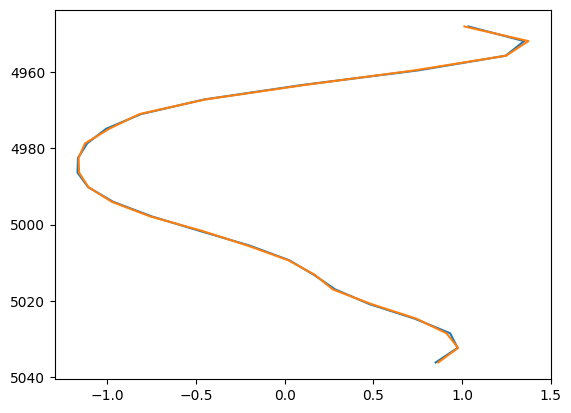

In [102]:
zz = np.linspace(depth_point1, depth_point2, synth9proj.shape[0] + 1)
plt.plot(sismica9, zz[:-1]);
plt.plot(synth9proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 12

In [86]:
idx12 = (twt12 > depth_point1) * (twt12 < depth_point2)
imp12 = vp12 * rho12

philow12 = escala_sismica(twt12[idx12], phi12[idx12], np.array(V3D.data), depth_point1, depth_point2)
implow12 = escala_sismica(twt12[idx12], imp12[idx12], np.array(V3D.data), depth_point1, depth_point2)

Rpp12 = RC_fwd_model_ia(implow12[:-1], implow12[1:])
Rpplast12 = 0.0 / implow12[0]
Rpp12 = np.concatenate([Rpp12, np.expand_dims(Rpplast12, axis = 0)], axis = 0)

0.8353119631965487


(24,)

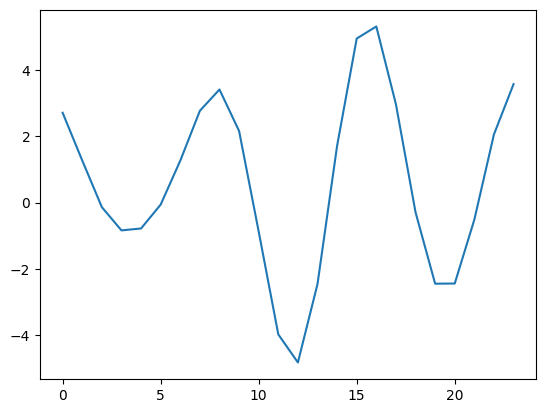

In [87]:
wvlt12, synth12 = wavl(Rpp12[:-1], sismica12)
plt.plot(wvlt12);
wvlt12.shape

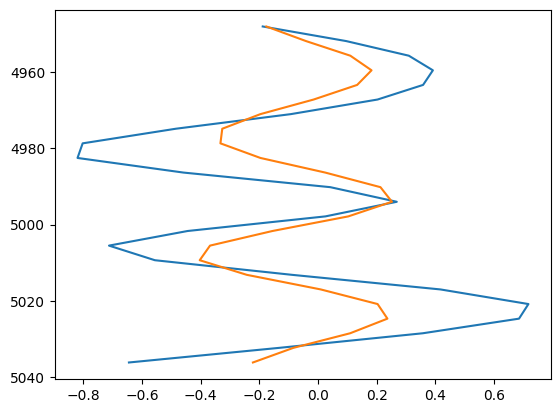

In [88]:
zz = np.linspace(depth_point1, depth_point2, synth12.shape[0] + 1)
plt.plot(sismica12, zz[:-1]);
plt.plot(synth12, zz[:-1]);
plt.gca().invert_yaxis();

0.9663223650239481


(24,)

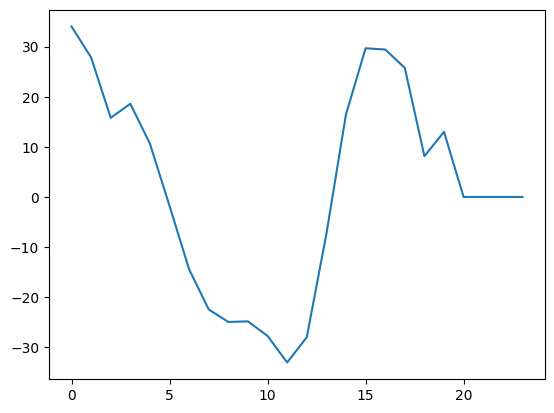

In [103]:
wvlt12proj, synth12proj = wavl(Rpp12[:-1], sismica12, proj = True)
plt.plot(wvlt12proj);
wvlt12proj.shape

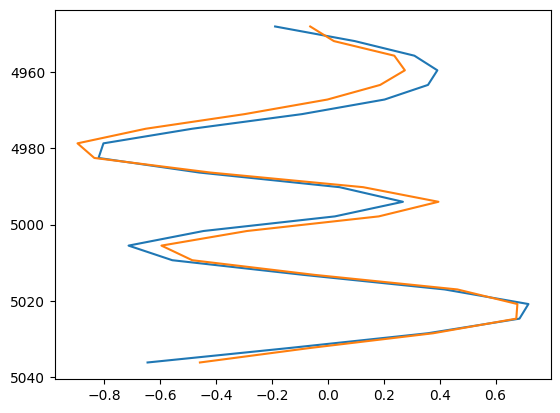

In [104]:
zz = np.linspace(depth_point1, depth_point2, synth12proj.shape[0] + 1)
plt.plot(sismica12, zz[:-1]);
plt.plot(synth12proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 14

In [89]:
idx14 = (twt14 > depth_point1) * (twt14 < depth_point2)
imp14 = vp14 * rho14

philow14 = escala_sismica(twt14[idx14], phi14[idx14], np.array(V3D.data), depth_point1, depth_point2)
implow14 = escala_sismica(twt14[idx14], imp14[idx14], np.array(V3D.data), depth_point1, depth_point2)

Rpp14 = RC_fwd_model_ia(implow14[:-1], implow14[1:])
Rpplast14 = 0.0 / implow14[0]
Rpp14 = np.concatenate([Rpp14, np.expand_dims(Rpplast14, axis = 0)], axis = 0)

0.0944430283149252


(24,)

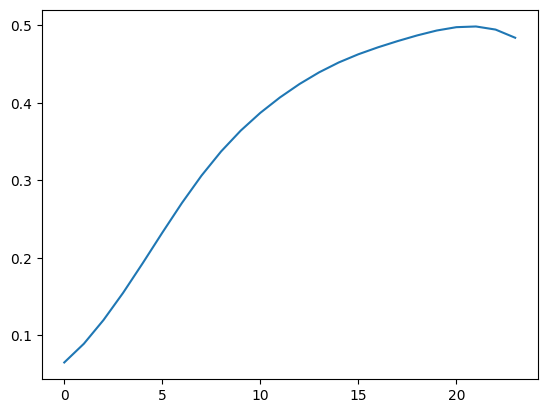

In [90]:
wvlt14, synth14 = wavl(Rpp14[:-1], sismica14)
plt.plot(wvlt14);
wvlt14.shape

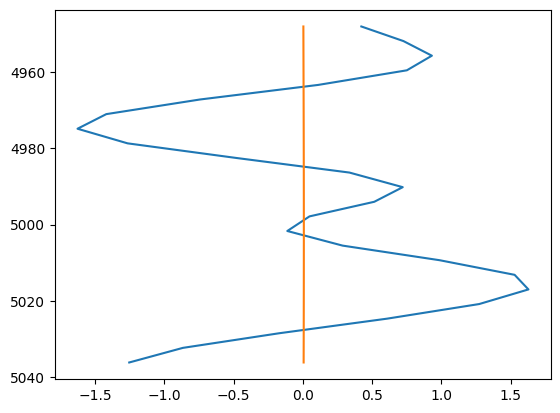

In [91]:
zz = np.linspace(depth_point1, depth_point2, synth14.shape[0] + 1)
plt.plot(sismica14, zz[:-1]);
plt.plot(synth14, zz[:-1]);
plt.gca().invert_yaxis();

0.9780719568703921


(24,)

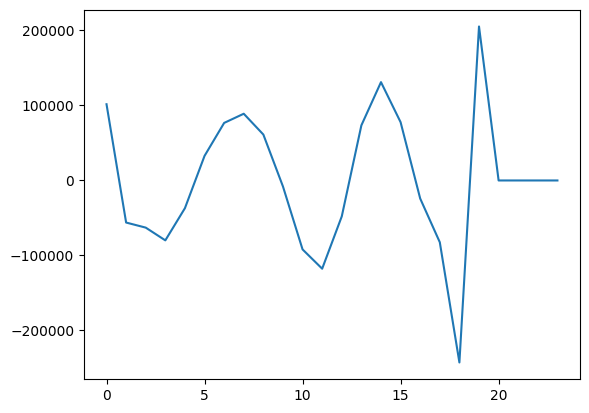

In [105]:
wvlt14proj, synth14proj = wavl(Rpp14[:-1], sismica14, proj = True)
plt.plot(wvlt14proj);
wvlt14proj.shape

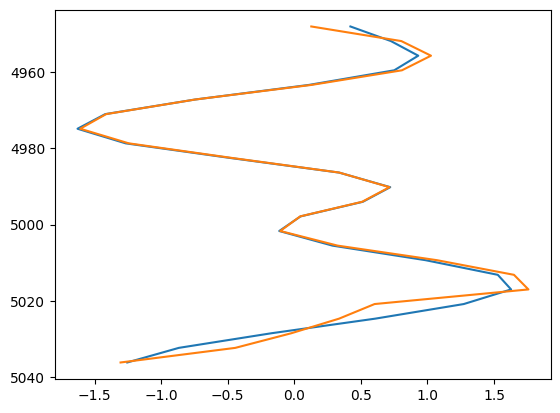

In [106]:
zz = np.linspace(depth_point1, depth_point2, synth14proj.shape[0] + 1)
plt.plot(sismica14, zz[:-1]);
plt.plot(synth14proj, zz[:-1]);
plt.gca().invert_yaxis();

## well 18

In [92]:
idx18 = (twt18 > depth_point1) * (twt18 < depth_point2)
imp18 = vp18 * rho18

philow18 = escala_sismica(twt18[idx18], phi18[idx18], np.array(V3D.data), depth_point1, depth_point2)
implow18 = escala_sismica(twt18[idx18], imp18[idx18], np.array(V3D.data), depth_point1, depth_point2)

Rpp18 = RC_fwd_model_ia(implow18[:-1], implow18[1:])
Rpplast18 = 0.0 / implow18[0]
Rpp18 = np.concatenate([Rpp18, np.expand_dims(Rpplast18, axis = 0)], axis = 0)

0.875004407819886


(24,)

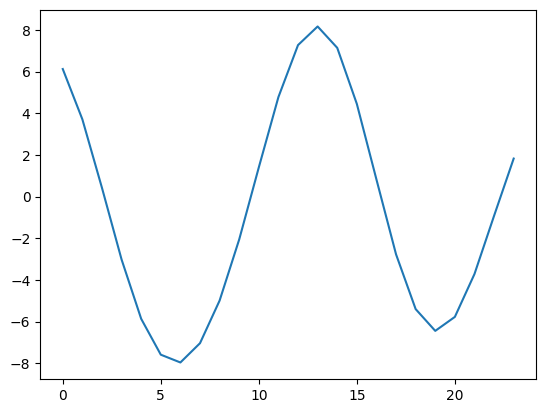

In [93]:
wvlt18, synth18 = wavl(Rpp18[:-1], sismica18)
plt.plot(wvlt18);
wvlt18.shape

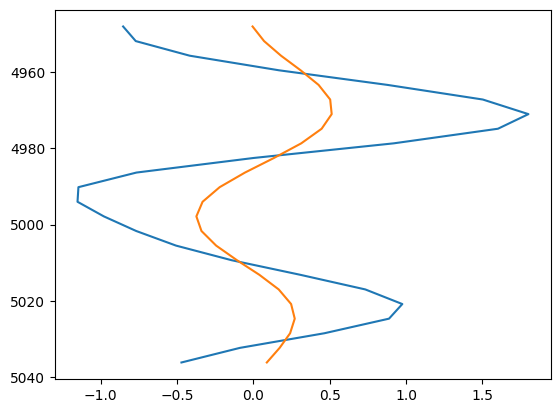

In [94]:
zz = np.linspace(depth_point1, depth_point2, synth18.shape[0] + 1)
plt.plot(sismica18, zz[:-1]);
plt.plot(synth18, zz[:-1]);
plt.gca().invert_yaxis();

0.9949922946149644


(24,)

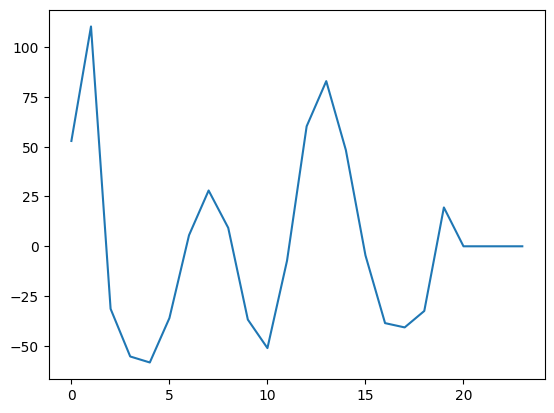

In [107]:
wvlt18proj, synth18proj = wavl(Rpp18[:-1], sismica18, proj = True)
plt.plot(wvlt18proj);
wvlt18proj.shape

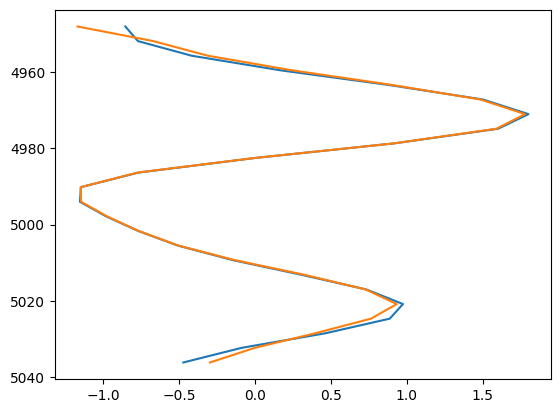

In [108]:
zz = np.linspace(depth_point1, depth_point2, synth18proj.shape[0] + 1)
plt.plot(sismica18, zz[:-1]);
plt.plot(synth18proj, zz[:-1]);
plt.gca().invert_yaxis();

# generalizaçao

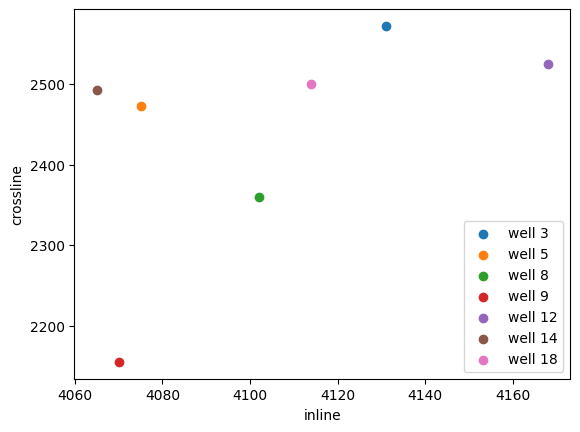

In [169]:
iis = [3, 5, 8, 9, 12, 14, 18]
[plt.scatter(coord[0], coord[1], label = 'well {}'.format(iis[ii])) for ii, coord in enumerate([coord3, coord5, coord8, coord9, coord12, coord14, coord18])];
plt.xlabel('inline'); plt.ylabel('crossline'); plt.legend();

## well3

(0.37114102104877716, -0.014239763535746634)

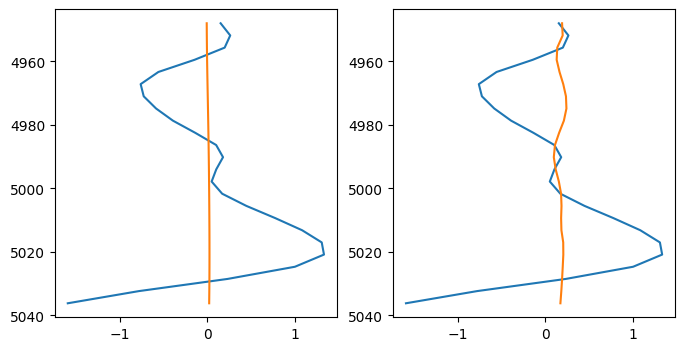

In [131]:
synth = cross(Rpp3[:-1], wvlt5)
synthproj = cross(Rpp3[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.42388709291823884, 0.42132185982955583)

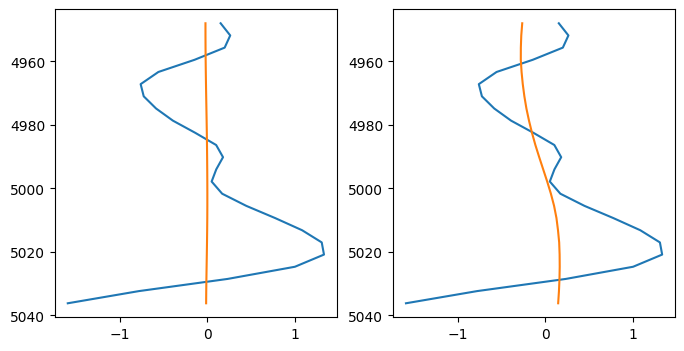

In [132]:
synth = cross(Rpp3[:-1], wvlt8)
synthproj = cross(Rpp3[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.10359810326071332, 0.1729852433640916)

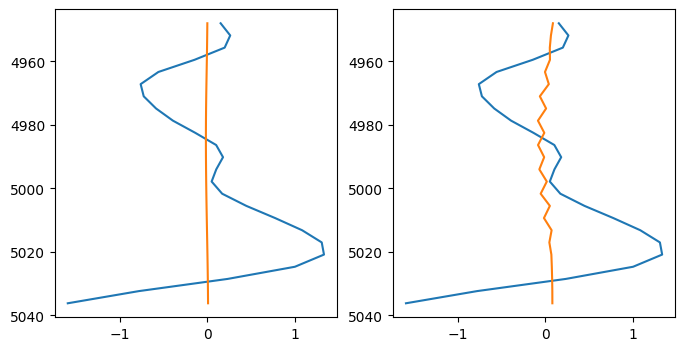

In [133]:
synth = cross(Rpp3[:-1], wvlt9)
synthproj = cross(Rpp3[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.40102681457801426, -0.2931550377273367)

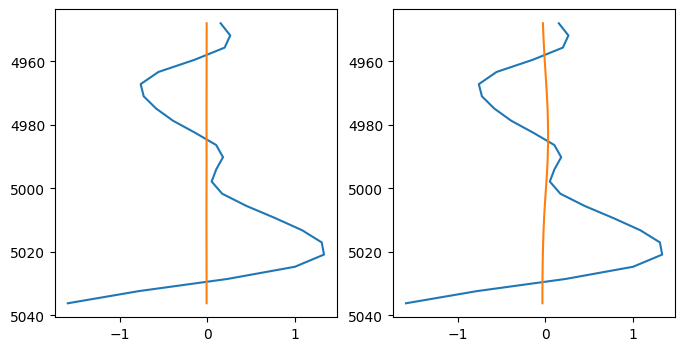

In [134]:
synth = cross(Rpp3[:-1], wvlt12)
synthproj = cross(Rpp3[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.3942544032445558, 0.46319984408350307)

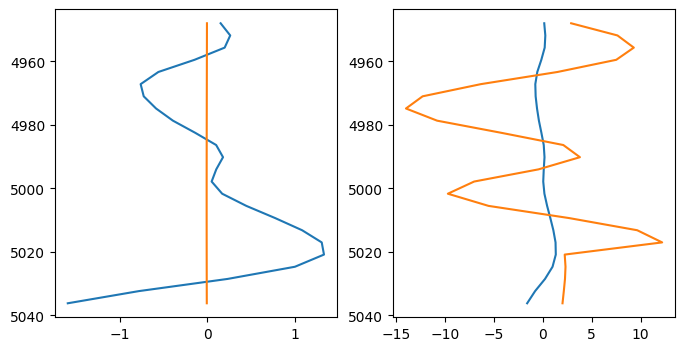

In [135]:
synth = cross(Rpp3[:-1], wvlt14)
synthproj = cross(Rpp3[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.4644885955304744, -0.07884957118818742)

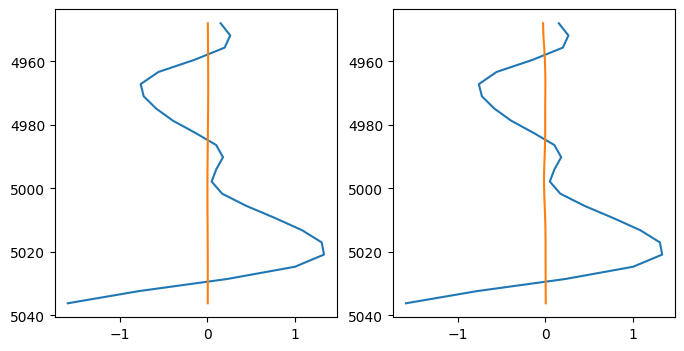

In [136]:
synth = cross(Rpp3[:-1], wvlt18)
synthproj = cross(Rpp3[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 5

(0.48485270682875, 0.02866069244123069)

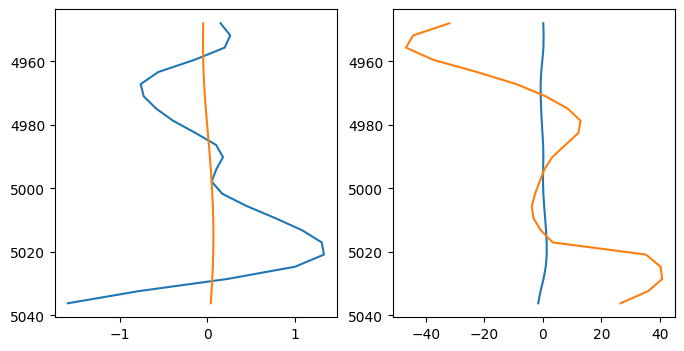

In [138]:
synth = cross(Rpp5[:-1], wvlt3)
synthproj = cross(Rpp5[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.33622291053168324, 0.4198408481935509)

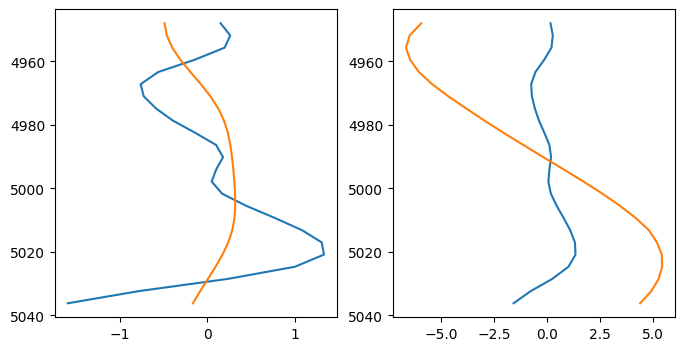

In [139]:
synth = cross(Rpp5[:-1], wvlt8)
synthproj = cross(Rpp5[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.017822546514679297, -0.05220597245095423)

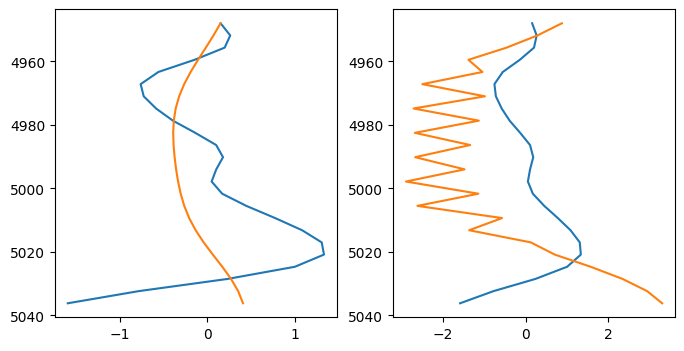

In [140]:
synth = cross(Rpp5[:-1], wvlt9)
synthproj = cross(Rpp5[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.22833599643808697, 0.0811004430129938)

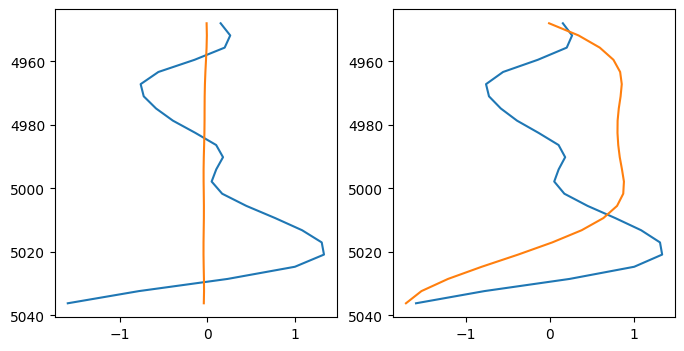

In [141]:
synth = cross(Rpp5[:-1], wvlt12)
synthproj = cross(Rpp5[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.44465118791536934, -0.3820307471517013)

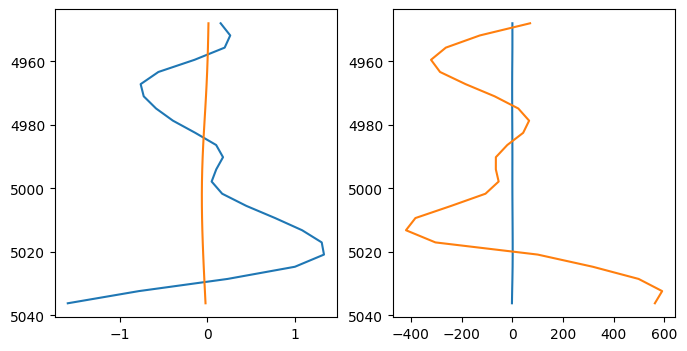

In [142]:
synth = cross(Rpp5[:-1], wvlt14)
synthproj = cross(Rpp5[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.245590944182492, -0.048971391350966786)

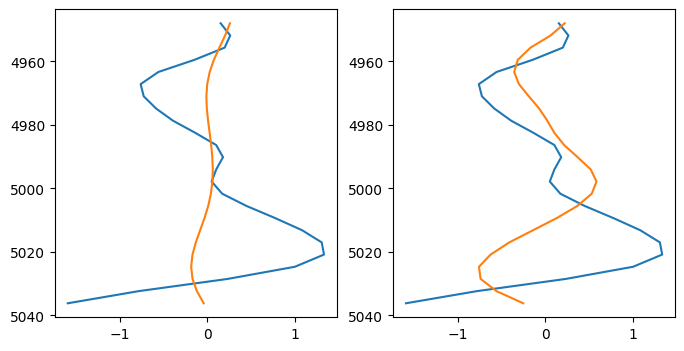

In [143]:
synth = cross(Rpp5[:-1], wvlt18)
synthproj = cross(Rpp5[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 8

(-0.49713928661727946, 0.020408096521686316)

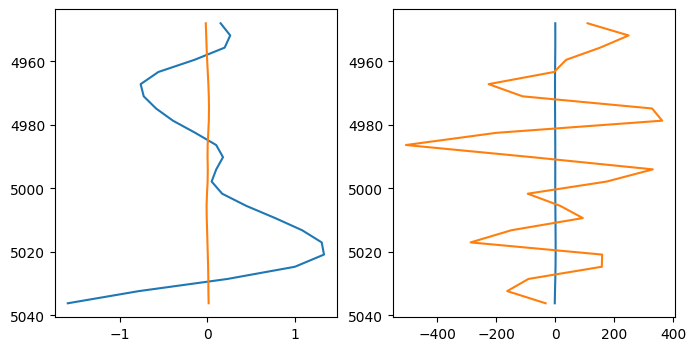

In [144]:
synth = cross(Rpp8[:-1], wvlt3)
synthproj = cross(Rpp8[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.1918840953700326, -0.2436920169296108)

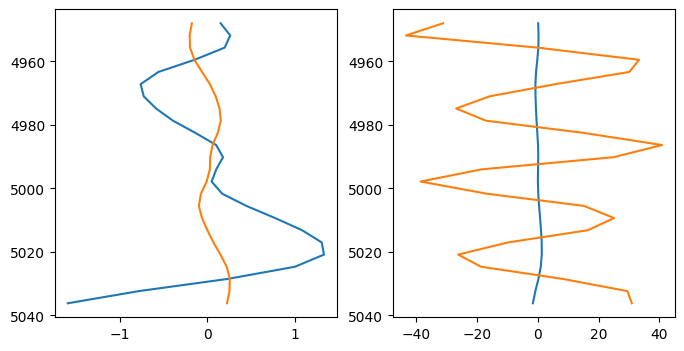

In [145]:
synth = cross(Rpp8[:-1], wvlt5)
synthproj = cross(Rpp8[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.054312785188540366, -0.08034183169272462)

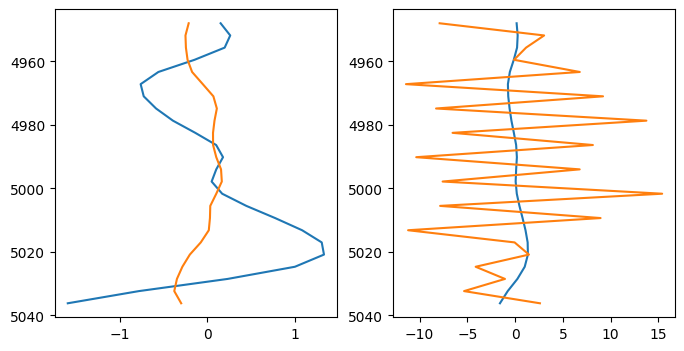

In [146]:
synth = cross(Rpp8[:-1], wvlt9)
synthproj = cross(Rpp8[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.21157411757881983, -0.006303800465635222)

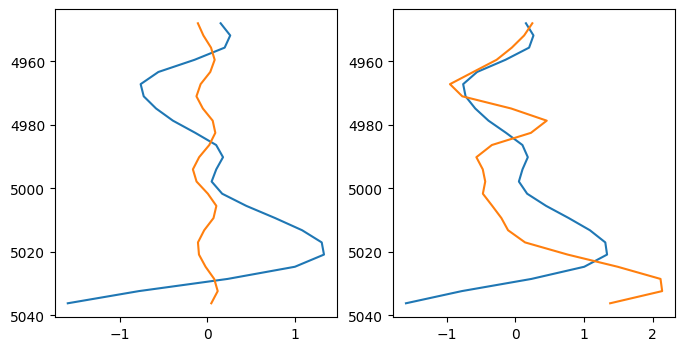

In [147]:
synth = cross(Rpp8[:-1], wvlt12)
synthproj = cross(Rpp8[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.03185592997390752, 0.18092960116385742)

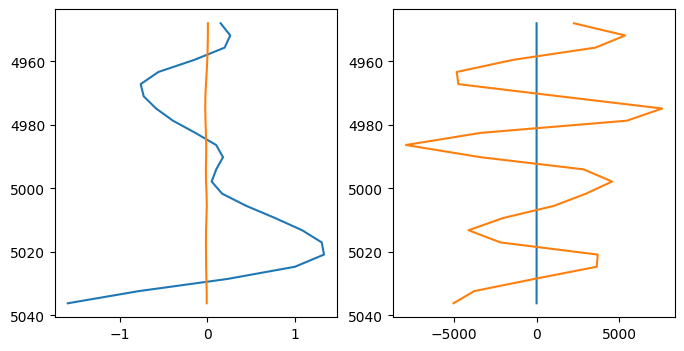

In [148]:
synth = cross(Rpp8[:-1], wvlt14)
synthproj = cross(Rpp8[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.3747144389352447, 0.3540195914717413)

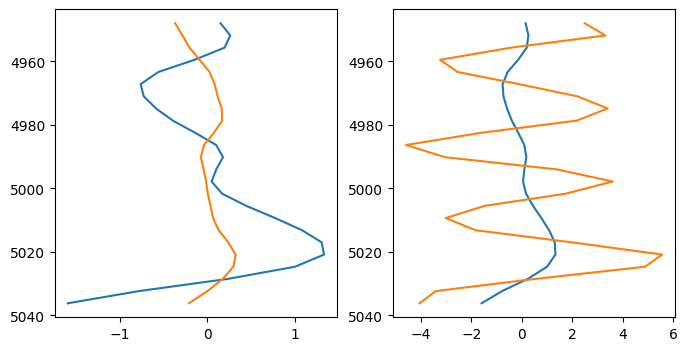

In [149]:
synth = cross(Rpp8[:-1], wvlt18)
synthproj = cross(Rpp8[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 9

(0.39569881705530424, 0.624260406025065)

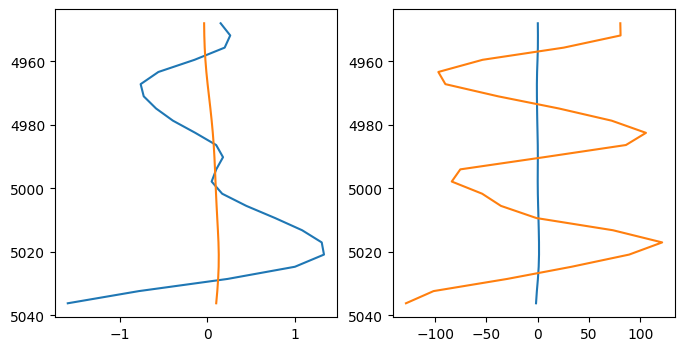

In [150]:
synth = cross(Rpp9[:-1], wvlt3)
synthproj = cross(Rpp9[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.38949985299832324, 0.09451653853400814)

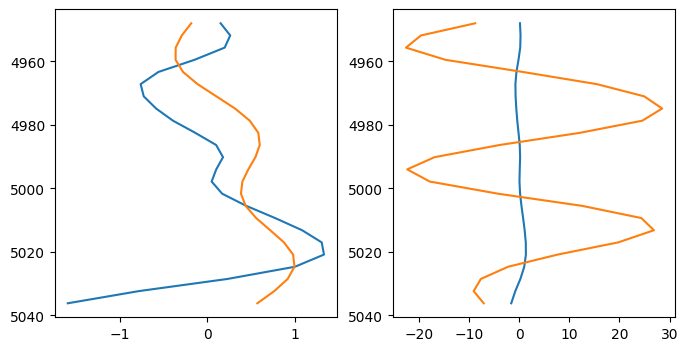

In [151]:
synth = cross(Rpp9[:-1], wvlt5)
synthproj = cross(Rpp9[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.3716721011001358, 0.27721239111632273)

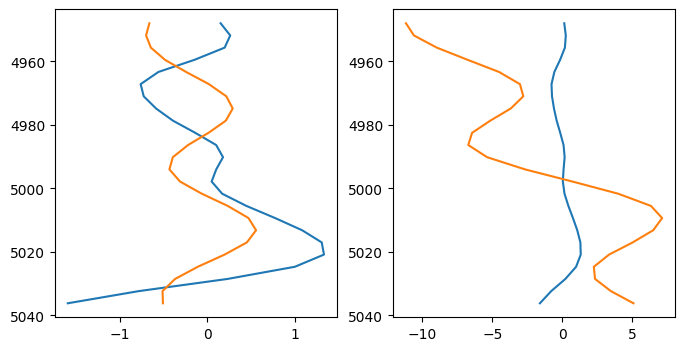

In [152]:
synth = cross(Rpp9[:-1], wvlt8)
synthproj = cross(Rpp9[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.07272625662465917, 0.08923131910042072)

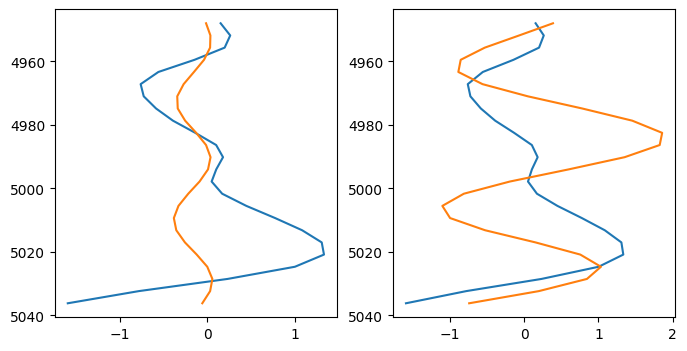

In [153]:
synth = cross(Rpp9[:-1], wvlt12)
synthproj = cross(Rpp9[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.3657529594652719, 0.30674357395222246)

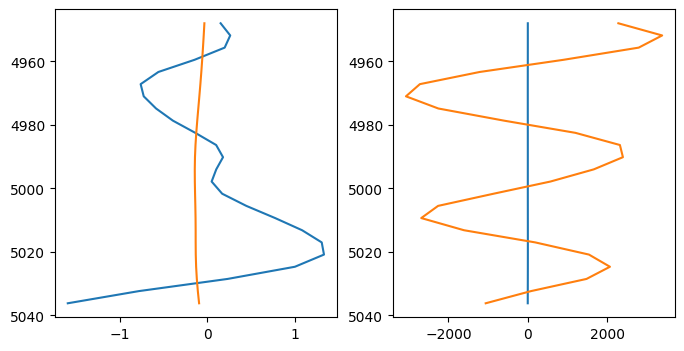

In [154]:
synth = cross(Rpp9[:-1], wvlt14)
synthproj = cross(Rpp9[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.2518383911110104, 0.2973650828961871)

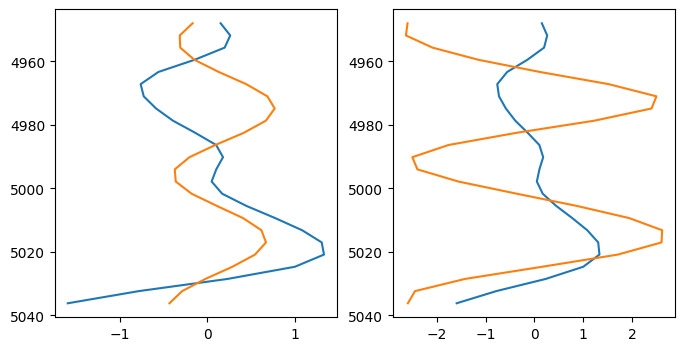

In [155]:
synth = cross(Rpp9[:-1], wvlt18)
synthproj = cross(Rpp9[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 12

(-0.039006877602590584, 0.32362458438723846)

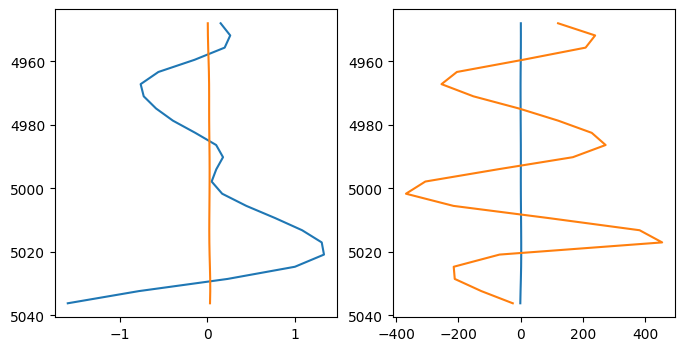

In [156]:
synth = cross(Rpp12[:-1], wvlt3)
synthproj = cross(Rpp12[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.31690723520872877, -0.2042838267828481)

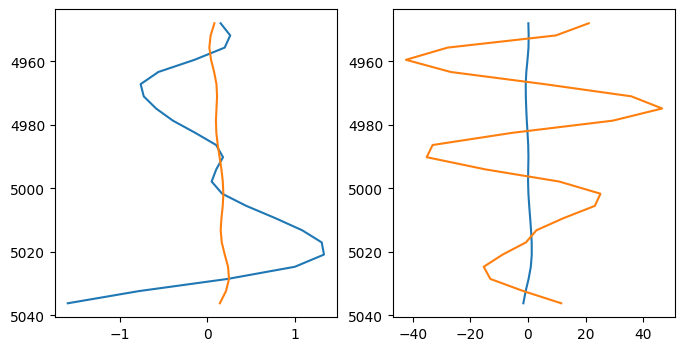

In [157]:
synth = cross(Rpp12[:-1], wvlt5)
synthproj = cross(Rpp12[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.30043672622214607, -0.48438607769849495)

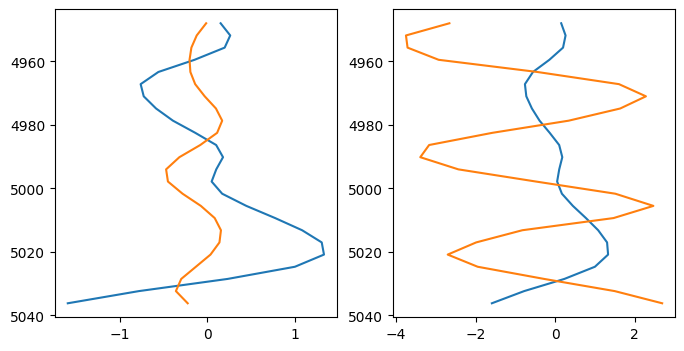

In [158]:
synth = cross(Rpp12[:-1], wvlt8)
synthproj = cross(Rpp12[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.1595275604698634, 0.010993293782683447)

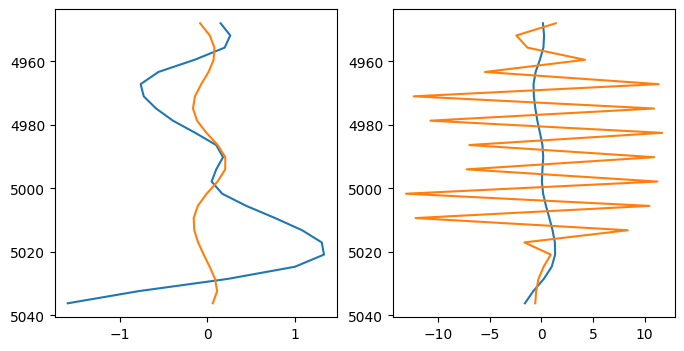

In [159]:
synth = cross(Rpp12[:-1], wvlt9)
synthproj = cross(Rpp12[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.05722002096612924, 0.37517979807068)

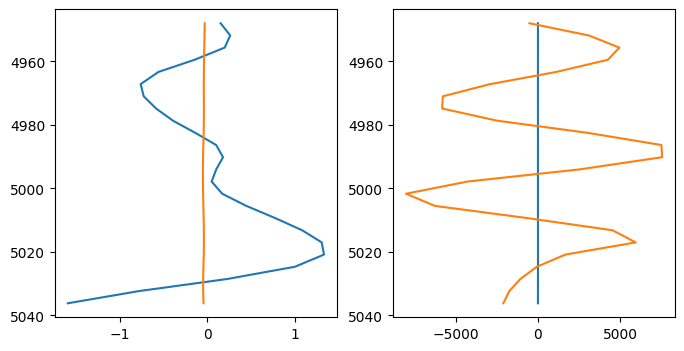

In [160]:
synth = cross(Rpp12[:-1], wvlt14)
synthproj = cross(Rpp12[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.5656367714039212, 0.23471005368821518)

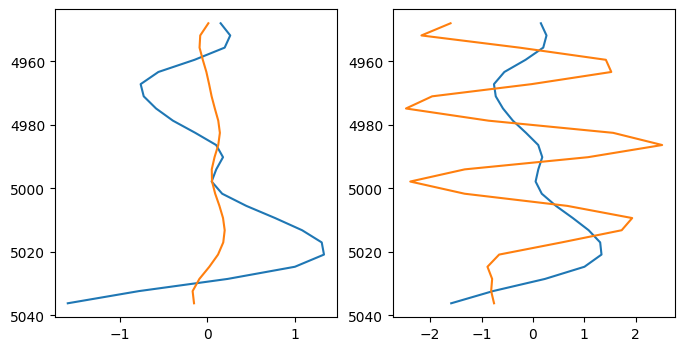

In [161]:
synth = cross(Rpp12[:-1], wvlt18)
synthproj = cross(Rpp12[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 14

(-0.34974805618917054, 0.6713160974311242)

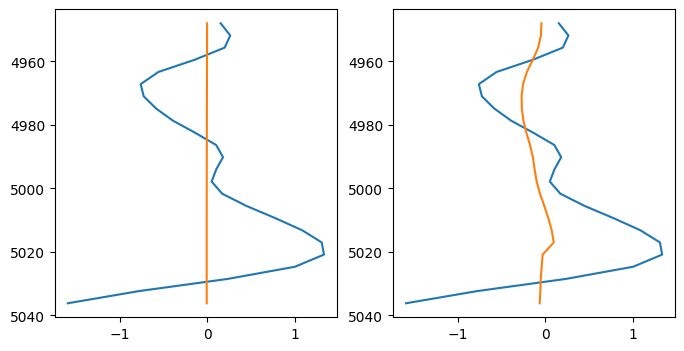

In [162]:
synth = cross(Rpp14[:-1], wvlt3)
synthproj = cross(Rpp14[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.36078221281009276, -0.1114075998459274)

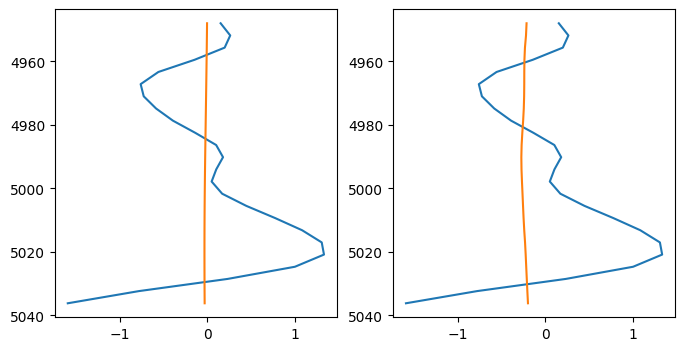

In [163]:
synth = cross(Rpp14[:-1], wvlt5)
synthproj = cross(Rpp14[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.3160832611334549, -0.29402259597440444)

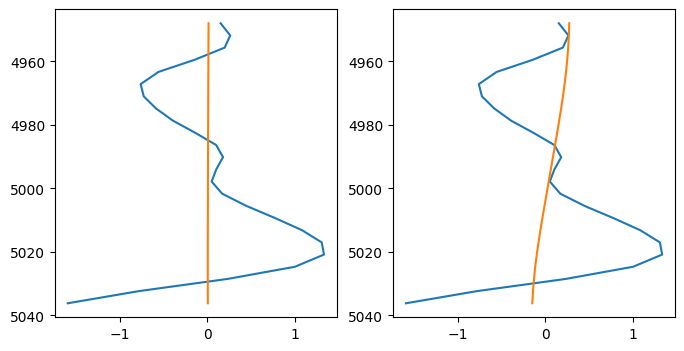

In [164]:
synth = cross(Rpp14[:-1], wvlt8)
synthproj = cross(Rpp14[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.10107525725778083, 0.3815890179050762)

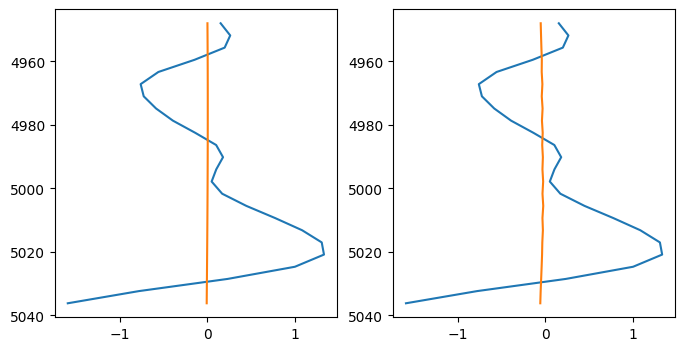

In [166]:
synth = cross(Rpp14[:-1], wvlt9)
synthproj = cross(Rpp14[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.25791648480434426, -0.1853448768112115)

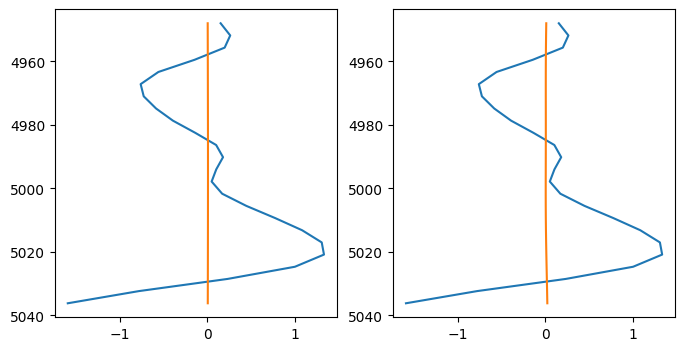

In [165]:
synth = cross(Rpp14[:-1], wvlt12)
synthproj = cross(Rpp14[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.09811209571088926, -0.3633411905370363)

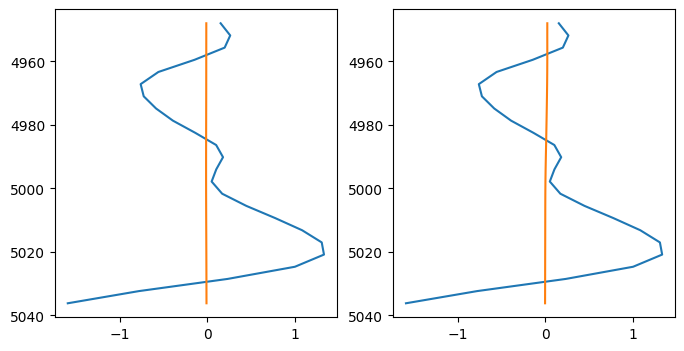

In [168]:
synth = cross(Rpp14[:-1], wvlt18)
synthproj = cross(Rpp14[:-1], wvlt18proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

## well 18

(0.5041803919430047, 0.1828098949412048)

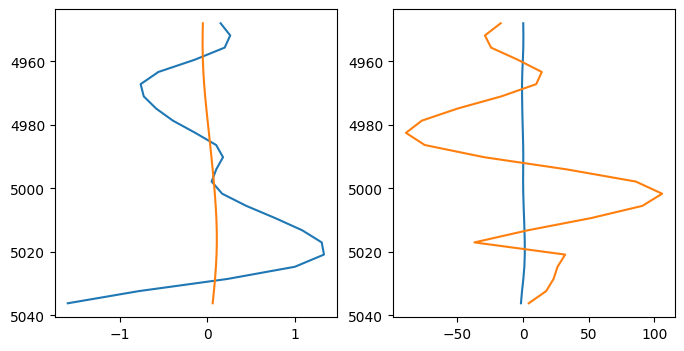

In [170]:
synth = cross(Rpp18[:-1], wvlt3)
synthproj = cross(Rpp18[:-1], wvlt3proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.3409168799079258, 0.2738002444829363)

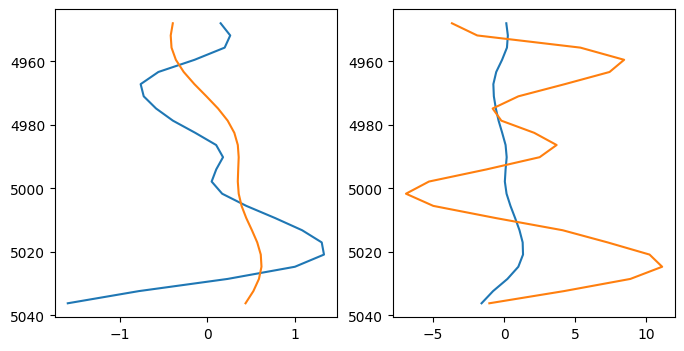

In [171]:
synth = cross(Rpp18[:-1], wvlt5)
synthproj = cross(Rpp18[:-1], wvlt5proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.4122175213081317, 0.5807323033837468)

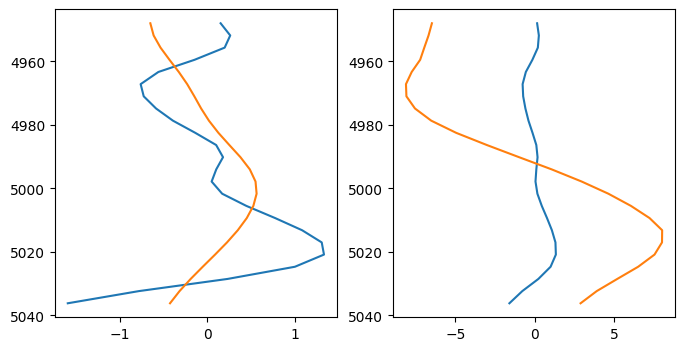

In [172]:
synth = cross(Rpp18[:-1], wvlt8)
synthproj = cross(Rpp18[:-1], wvlt8proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(0.09869314809691518, 0.21703021672523395)

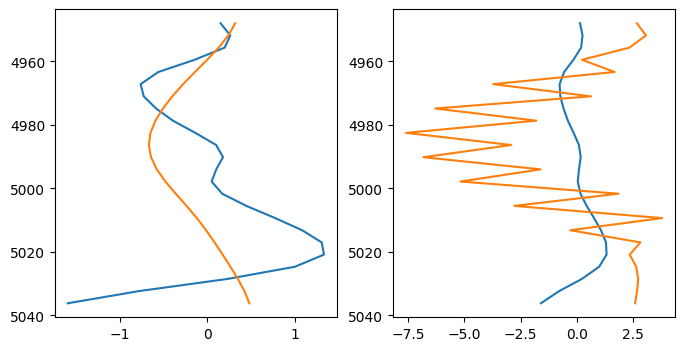

In [173]:
synth = cross(Rpp18[:-1], wvlt9)
synthproj = cross(Rpp18[:-1], wvlt9proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.5055328223314765, -0.37497845104763833)

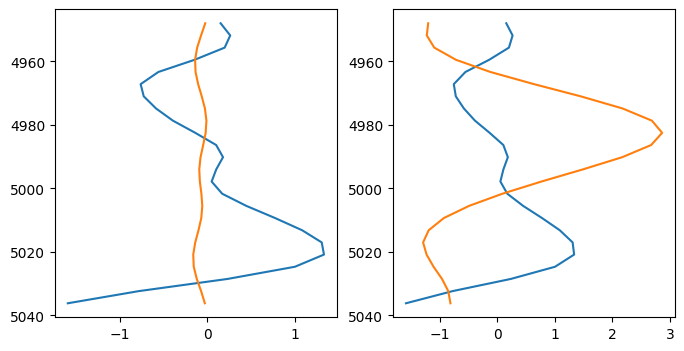

In [174]:
synth = cross(Rpp18[:-1], wvlt12)
synthproj = cross(Rpp18[:-1], wvlt12proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

(-0.45206868525372135, -0.2640244016299995)

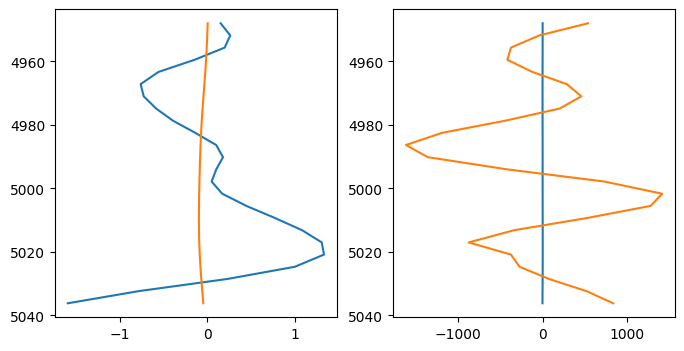

In [175]:
synth = cross(Rpp18[:-1], wvlt14)
synthproj = cross(Rpp18[:-1], wvlt14proj)

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
axes[0].plot(sismica3, zz[:-1]);
axes[0].plot(synth, zz[:-1]);
axes[0].invert_yaxis();

axes[1].plot(sismica3, zz[:-1]);
axes[1].plot(synthproj, zz[:-1]);
axes[1].invert_yaxis();
np.corrcoef(sismica3, synth)[0][1], np.corrcoef(sismica3, synthproj)[0][1]

# export

(69,)

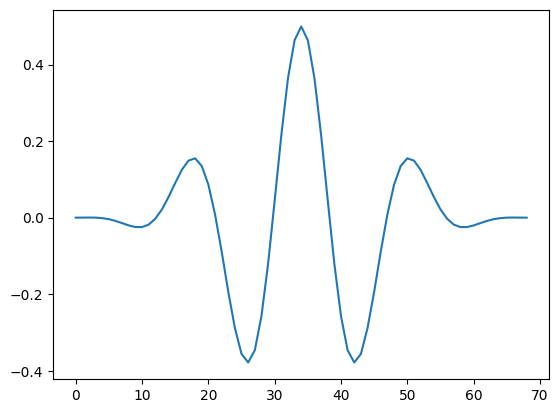

In [181]:
df_15_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_15_2_30.dat', 
                           header = None, sep = '\t')
wvlt_15_2_30 = df_15_2_30[1].values
plt.plot(wvlt_15_2_30);
wvlt_15_2_30.shape

(24,)

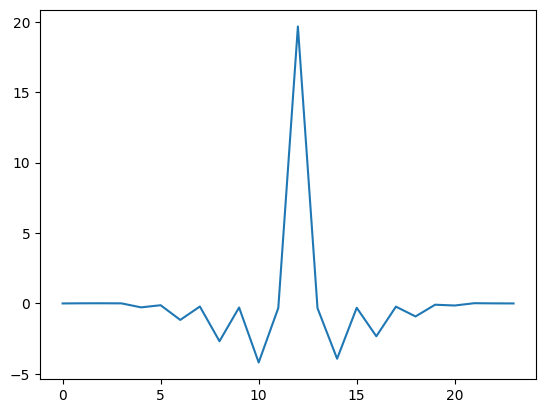

In [182]:
df_90_20_probe = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/WAV_90_20_probe.dat', 
                           header = None, sep = '\t')
wvlt_90_20_probe = df_90_20_probe[1].values
plt.plot(wvlt_90_20_probe);
wvlt_90_20_probe.shape

(24,)

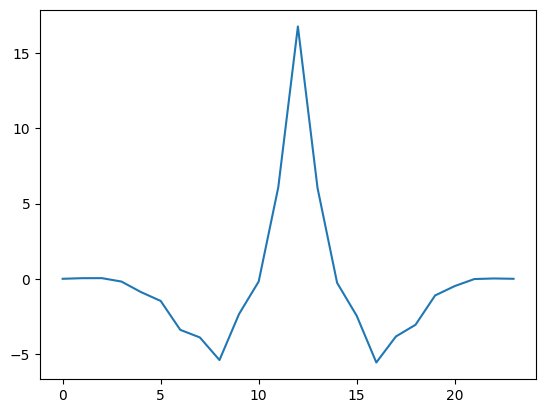

In [183]:
df_sul_90 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_area_menor_sul_90.dat', 
                           header = None, sep = '\t')
wvlt_sul_90 = df_sul_90[1].values
plt.plot(wvlt_sul_90);
wvlt_sul_90.shape

(35,)

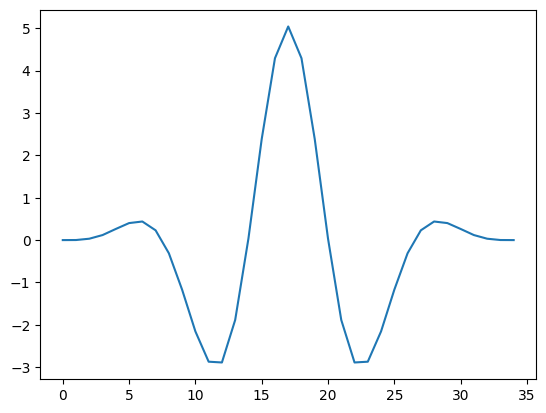

In [184]:
df_sinc_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_sinc_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_sinc_30_2_30 = df_sinc_30_2_30[1].values
plt.plot(wvlt_sinc_30_2_30);
wvlt_sinc_30_2_30.shape

(51,)

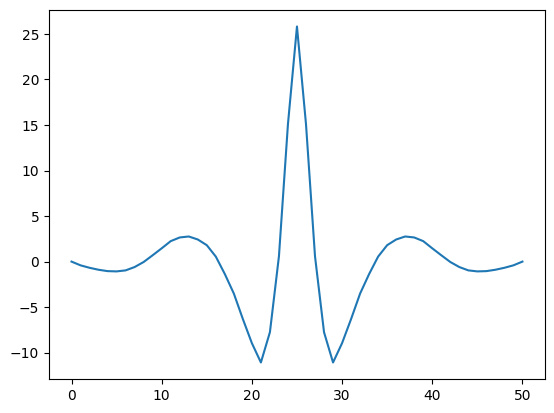

In [185]:
df_200_50 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_200_50.dat', 
                           header = None, sep = '\t')
wvlt_200_50 = df_200_50[1].values
plt.plot(wvlt_200_50);
wvlt_200_50.shape

(51,)

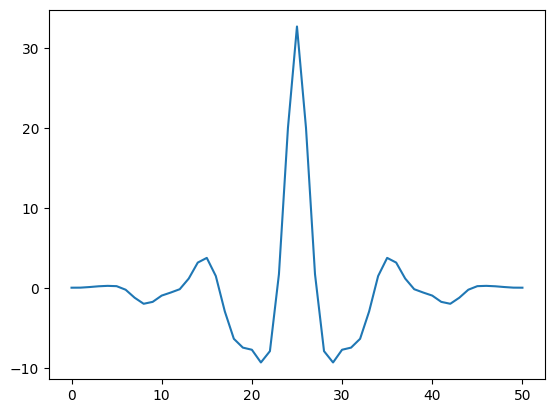

In [186]:
df_200_50_probe = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_200_50_probe.dat', 
                           header = None, sep = '\t')
wvlt_200_50_probe = df_200_50_probe[1].values
plt.plot(wvlt_200_50_probe);
wvlt_200_50_probe.shape

(35,)

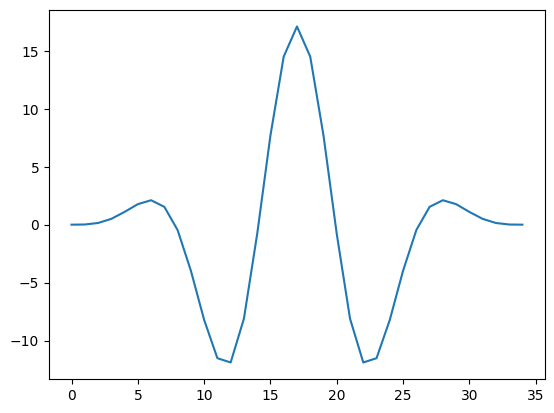

In [187]:
df_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wav_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_30_2_30 = df_30_2_30[1].values
plt.plot(wvlt_30_2_30);
wvlt_30_2_30.shape

(35,)

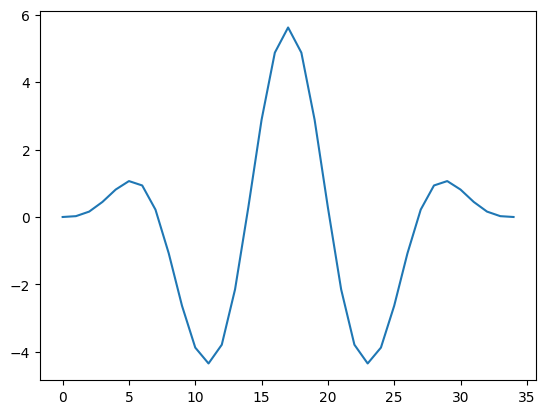

In [188]:
df_s_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wav_s_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_s_30_2_30 = df_s_30_2_30[1].values
plt.plot(wvlt_s_30_2_30);
wvlt_s_30_2_30.shape

## well 3

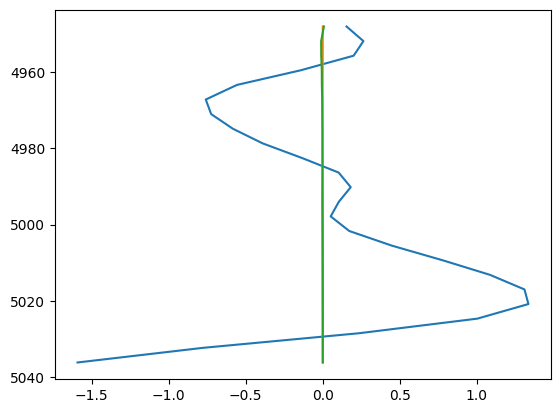

In [198]:
synth = cross(Rpp3[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp3[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

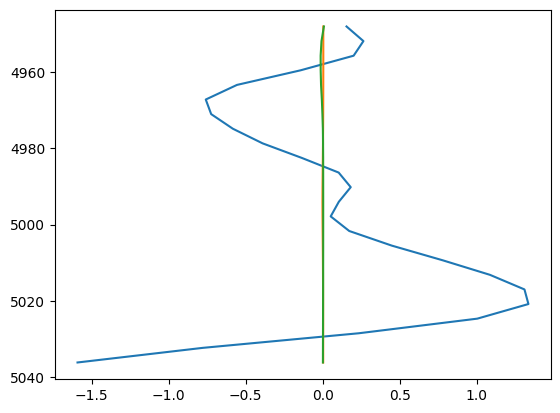

In [199]:
synth = cross(Rpp3[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp3[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 5

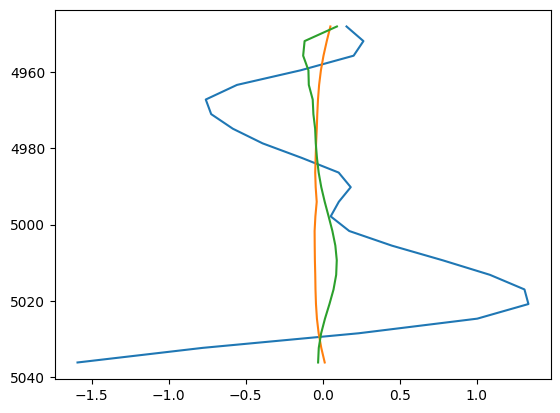

In [200]:
synth = cross(Rpp5[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp5[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

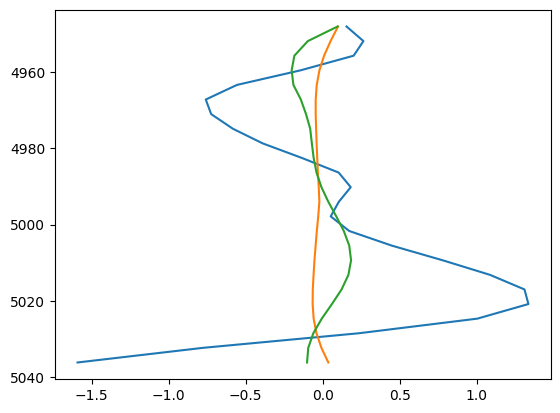

In [201]:
synth = cross(Rpp5[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp5[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 8

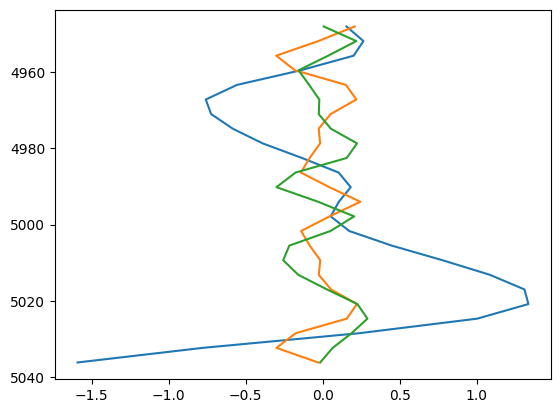

In [202]:
synth = cross(Rpp8[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp8[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

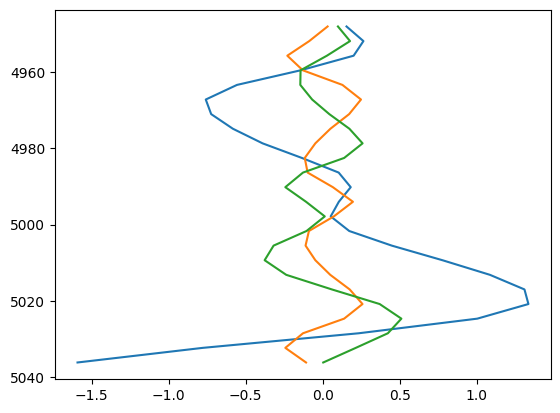

In [203]:
synth = cross(Rpp8[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp8[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 9

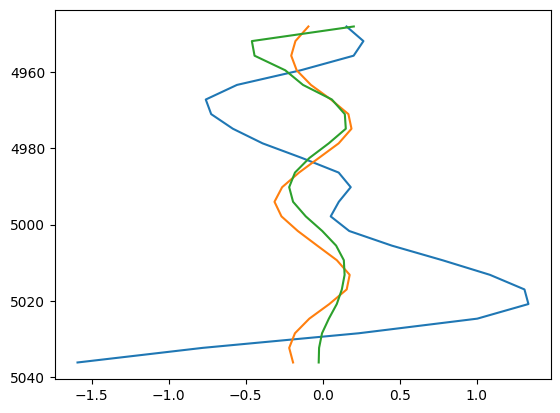

In [204]:
synth = cross(Rpp9[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp9[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

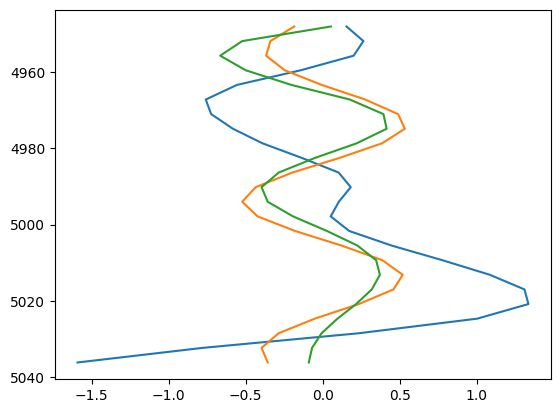

In [205]:
synth = cross(Rpp9[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp9[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 12

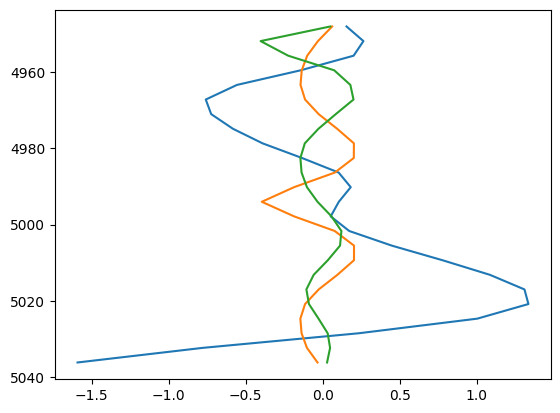

In [206]:
synth = cross(Rpp12[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp12[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

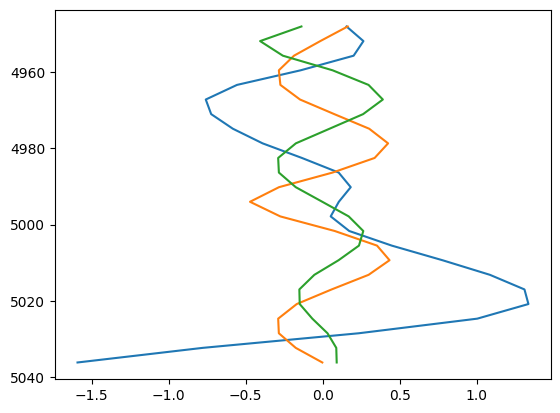

In [207]:
synth = cross(Rpp12[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp12[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 14

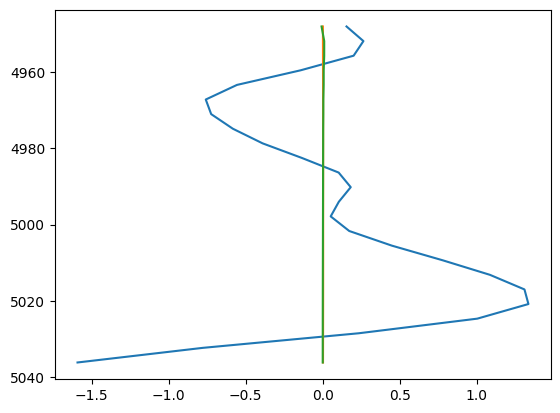

In [208]:
synth = cross(Rpp14[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp14[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

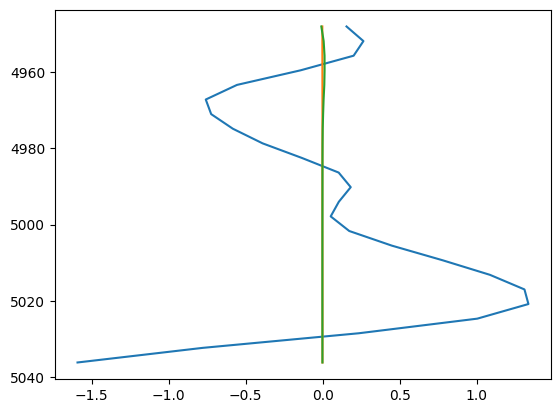

In [209]:
synth = cross(Rpp14[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp14[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

## well 18

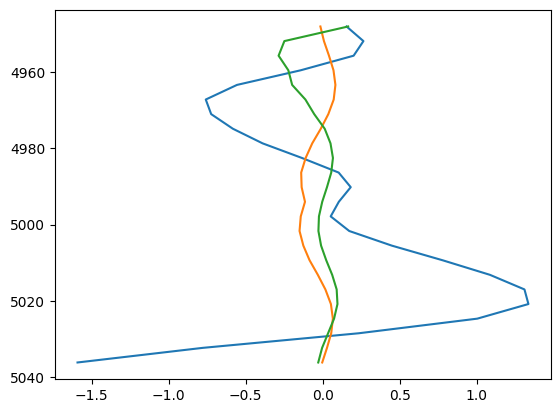

In [210]:
synth = cross(Rpp18[:-1], wvlt_90_20_probe)
synthconv = np.convolve(wvlt_90_20_probe, Rpp18[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();

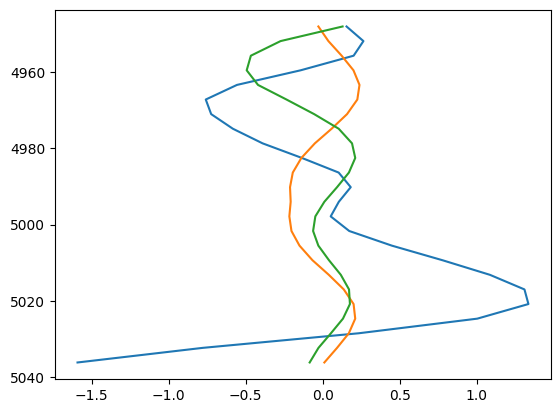

In [211]:
synth = cross(Rpp18[:-1], wvlt_sul_90)
synthconv = np.convolve(wvlt_sul_90, Rpp18[:-1], mode='same')

zz = np.linspace(depth_point1, depth_point2, synth.shape[0] + 1)
plt.plot(sismica3, zz[:-1]);
plt.plot(synth, zz[:-1]);
plt.plot(synthconv, zz[:-1]);
plt.gca().invert_yaxis();